In [1]:
from curl_cffi import requests
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

session = requests.Session(impersonate="chrome")

sp500 = yf.Ticker("^GSPC", session=session).history(period="max")
sp500 = sp500[["Open", "High", "Low", "Close", "Volume"]]
sp500.to_csv("sp500_data.csv")


In [2]:
sp500 = pd.read_csv("sp500_data.csv", index_col=0, parse_dates=True)

In [3]:
sp500


,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2025-05-19 00:00:00-04:00,5902.879883,5968.609863,5895.689941,5963.600098,4144010000
2025-05-20 00:00:00-04:00,5944.660156,5953.060059,5909.259766,5940.459961,4416850000
2025-05-21 00:00:00-04:00,5910.180176,5938.370117,5830.910156,5844.609863,5254250000


In [4]:
#Feature Engineering
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

for window in [5, 10, 20, 50, 100]:
    sp500[f"MA_{window}"] = sp500["Close"].rolling(window).mean()
    sp500[f"Momentum_{window}"] = sp500["Close"] - sp500["Close"].shift(window)
    sp500[f"Volatility_{window}"] = sp500["Close"].rolling(window).std()

sp500 = sp500.dropna()


In [5]:
#Preparing train test split
features = [col for col in sp500.columns if col not in ["Tomorrow", "Target"]]
train_size = int(len(sp500) * 0.8)
train = sp500.iloc[:train_size]
test = sp500.iloc[train_size:]

In [6]:
# Train the model
model = RandomForestClassifier(n_estimators=500, min_samples_split=10, random_state=1)
model.fit(train[features], train["Target"])

# Predict with default threshold 0.5
preds = model.predict(test[features])

# Evaluate precision, recall, accuracy, and F1-score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

precision = precision_score(test["Target"], preds)
recall = recall_score(test["Target"], preds)
accuracy = accuracy_score(test["Target"], preds)
f1 = f1_score(test["Target"], preds)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"Accuracy:  {accuracy:.3f}")
print(f"F1 Score:  {f1:.3f}")


Precision: 0.565
Recall:    0.271
Accuracy:  0.490
F1 Score:  0.366


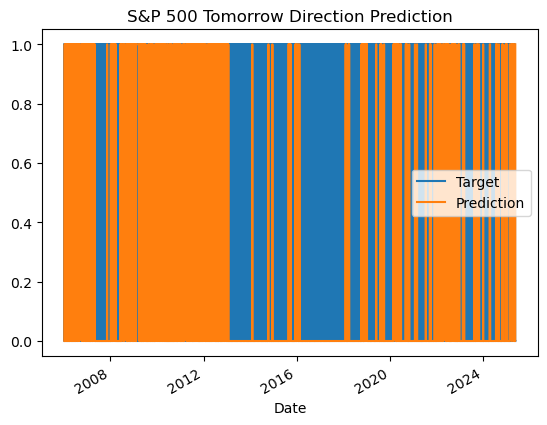

In [7]:
results = pd.DataFrame({"Target": test["Target"], "Prediction": preds}, index=test.index)
results.plot(title="S&P 500 Tomorrow Direction Prediction")
plt.show()